# Lista E2 – Modelagem de RENTPL
Este notebook segue os seis itens da lista E2, construindo e avaliando modelos de regressão para explicar **RENTPL** a partir da base `fipecafi_cap3.csv`. Cada seção indica claramente como o requisito do enunciado foi atendido, desde a preparação dos dados até a justificativa do melhor modelo.

## 1. Configurar Ambiente Python
Carregamos as bibliotecas necessárias e definimos opções globais para garantir reprodutibilidade e visualizações consistentes.

In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import statsmodels.api as sm
from IPython.display import display, Markdown

warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option("display.float_format", lambda x: f"{x:.4f}")
plt.style.use("seaborn-v0_8")

RANDOM_STATE = 42

## 2. Carregar e Explorar Dados
Carregamos a base contábil original, validamos colunas e investigamos valores ausentes para compreender o ponto de partida.

In [2]:
BASE_PATH = Path("c:/Users/gabri/OneDrive/Documentos/Documentos/projetos/analise-de-dados/lista2")
DATA_PATH = BASE_PATH / "fipecafi_cap3.csv"

raw_df = pd.read_csv(DATA_PATH)

print(f"Dimensão original: {raw_df.shape[0]} linhas x {raw_df.shape[1]} colunas")
display(raw_df.head())
print("\nResumo de tipos:")
print(raw_df.dtypes)

print("\nValores ausentes por coluna:")
print(raw_df.isna().sum())

Dimensão original: 297 linhas x 11 colunas


,ID,VENDAS,PLAJUST,LLAJUST,ATIVOAJ,ALOPER,MARVEN,RENTAT,ALFIN,LUPRE,RENTPL
0,1001,33311.5000,14176.4000,2660.5000,36658.5000,2.5900,0.0800,0.0700,0.9100,1,0.1900
1,1002,5329.8000,478.6000,-1350.0000,3901.3000,8.1500,-0.2500,-0.3500,1.3700,0,-2.8200
2,1003,4310.4000,4650.4000,3180.0000,7819.4000,1.6800,0.7400,0.4100,0.5500,1,0.6800
3,1004,4214.1000,333.4000,-52.7000,757.9000,2.2700,-0.0100,-0.0700,5.5600,0,-0.1600
4,1005,4096.8000,1239.2000,-1290.0000,2575.7000,2.0800,-0.3100,-0.5000,1.5900,0,-1.0400



Resumo de tipos:
ID           int64
VENDAS     float64
PLAJUST    float64
LLAJUST    float64
ATIVOAJ    float64
ALOPER     float64
MARVEN     float64
RENTAT     float64
ALFIN      float64
LUPRE        int64
RENTPL     float64
dtype: object

Valores ausentes por coluna:
ID         0
VENDAS     0
PLAJUST    0
LLAJUST    0
ATIVOAJ    0
ALOPER     0
MARVEN     0
RENTAT     0
ALFIN      0
LUPRE      0
RENTPL     0
dtype: int64


## 3. Filtrar Registros por IDs Selecionados
Selecionamos exatamente 250 observações conforme a faixa de IDs definida para o código USP escolhido. Ajuste o código USP abaixo caso necessário.

In [ ]:
id_intervals = {
    4818232: (1047, 1296),
    10769897: (1035, 1284),
    11275126: (1039, 1288),
    11299828: (1020, 1269),
    11797038: (1029, 1278),
    11819240: (1034, 1283),
    12503841: (1012, 1261),
    12557546: (1045, 1294),
    12563690: (1014, 1263),
    12609046: (1010, 1259),
    12643618: (1037, 1286),
    12682435: (1031, 1280),
    12691710: (1027, 1276),
    12725025: (1042, 1291),
    13672922: (1040, 1289),
    13692272: (1028, 1277),
    13692400: (1011, 1260),
    13696658: (1018, 1267),
    13717786: (1015, 1264),
    13730051: (1009, 1258),
    13731066: (1046, 1295),
    13731344: (1044, 1293),
    13828592: (1032, 1281),
    13874729: (1024, 1273),
    14651980: (1036, 1285),
    14673946: (1038, 1287),
    15445352: (1033, 1282),
    15464079: (1017, 1266),
    15475961: (1023, 1272),
    15478710: (1026, 1275),
    15484839: (1013, 1262),
    15525671: (1016, 1265),
    15576244: (1021, 1270),
    15676493: (1043, 1292),
    16863830: (1025, 1274),
    16869840: (1041, 1290),
    16876716: (1030, 1279),
    17014744: (1022, 1271),
    17070887: (1019, 1268),
}

codigo_usp = 13874729  # ajuste aqui para seu código USP
id_inicial, id_final = id_intervals[codigo_usp]
id_selecionados = set(range(id_inicial, id_final + 1))

filtered_df = raw_df[raw_df["ID"].isin(id_selecionados)].copy()
filtered_df = filtered_df.sort_values("ID").reset_index(drop=True)

assert filtered_df.shape[0] == 250, "A filtragem deve resultar exatamente em 250 observações."
print(f"Intervalo usado: {id_inicial} a {id_final}")
print(f"Dimensão após filtro: {filtered_df.shape[0]} linhas x {filtered_df.shape[1]} colunas")
display(filtered_df.head())

Intervalo usado: 1019 a 1268
Dimensão após filtro: 250 linhas x 11 colunas


,ID,VENDAS,PLAJUST,LLAJUST,ATIVOAJ,ALOPER,MARVEN,RENTAT,ALFIN,LUPRE,RENTPL
0,1019,1760.4000,488.7000,22.7000,1654.6000,3.3900,0.0100,0.0100,1.0600,1,0.0500
1,1020,1752.1000,1376.2000,102.5000,2485.2000,1.8100,0.0600,0.0400,0.7100,1,0.0700
2,1021,1601.4000,5769.4000,28.9000,10304.2000,1.7900,0.0200,0.0000,0.1600,1,0.0100
3,1022,1551.2000,1448.7000,-165.4000,3483.5000,2.4000,-0.1100,-0.0500,0.4500,0,-0.1100
4,1023,1550.5000,164.9000,32.4000,1194.9000,7.2500,0.0200,0.0300,1.3000,1,0.2000


## 4. Preparar Conjuntos de Treino e Teste
Definimos RENTPL como variável resposta, removemos o identificador e particionamos a amostra em 70% treino e 30% teste.

In [6]:
feature_columns = [col for col in filtered_df.columns if col not in {"ID", "RENTPL"}]
X = filtered_df[feature_columns]
y = filtered_df["RENTPL"]

missing_features = X.isna().sum()
missing_target = y.isna().sum()
print("Valores ausentes em preditores:")
print(missing_features[missing_features > 0] if missing_features.sum() > 0 else "Nenhum")
print(f"Valores ausentes em RENTPL: {missing_target}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

print(f"Tamanho treino: {X_train.shape[0]} observações")
print(f"Tamanho teste: {X_test.shape[0]} observações")

metrics_records = []
residuals_data = {}


def collect_metrics(model_name: str, split_name: str, y_true, y_pred) -> None:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics_records.append(
        {
            "Modelo": model_name,
            "Base": split_name,
            "RMSE": rmse,
            "R2": r2_score(y_true, y_pred),
            "MAE": mean_absolute_error(y_true, y_pred),
        }
    )

Valores ausentes em preditores:
Nenhum
Valores ausentes em RENTPL: 0
Tamanho treino: 175 observações
Tamanho teste: 75 observações


## 5. Treinar Regressão Linear e Capturar Métricas
Ajustamos um modelo linear clássico e calculamos RMSE, $R^2$ e MAE para as bases de treino e teste.

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_train_pred = lin_reg.predict(X_train)
lin_test_pred = lin_reg.predict(X_test)

collect_metrics("Regressão Linear", "Treino", y_train, lin_train_pred)
collect_metrics("Regressão Linear", "Teste", y_test, lin_test_pred)

linear_metrics = pd.DataFrame(
    [
        {"Base": "Treino", "RMSE": np.sqrt(mean_squared_error(y_train, lin_train_pred)), "R2": r2_score(y_train, lin_train_pred), "MAE": mean_absolute_error(y_train, lin_train_pred)},
        {"Base": "Teste", "RMSE": np.sqrt(mean_squared_error(y_test, lin_test_pred)), "R2": r2_score(y_test, lin_test_pred), "MAE": mean_absolute_error(y_test, lin_test_pred)},
    ]
)

residuals_data["Regressão Linear"] = pd.DataFrame(
    {
        "RENTPL": y_test.reset_index(drop=True),
        "Estimado": lin_test_pred,
        "Residuo": y_test.reset_index(drop=True) - lin_test_pred,
    }
)

display(linear_metrics)

,Base,RMSE,R2,MAE
0,Treino,0.5276,0.9258,0.2799
1,Teste,34.6577,0.1256,4.2080


## 6. Extrair Coeficientes, Equação e Valores-P
Utilizamos `statsmodels` para obter a equação completa, os coeficientes estimados e a significância (valores-p) do modelo linear.

In [9]:
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()

display(ols_model.summary())

coef_table = pd.DataFrame(
    {
        "Coeficiente": ols_model.params,
        "Erro Padrão": ols_model.bse,
        "t": ols_model.tvalues,
        "p-valor": ols_model.pvalues,
    }
)

intercept = ols_model.params["const"]
terms = [f"{intercept:.4f}"]
for col in feature_columns:
    coef = ols_model.params[col]
    sinal = "+" if coef >= 0 else "-"
    terms.append(f" {sinal} {abs(coef):.4f} \\times {col}")

eq_tex = "$$\\widehat{\\text{RENTPL}} = " + "".join(terms) + "$$"

display(Markdown(eq_tex))
display(coef_table)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RENTPL   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     228.6
Date:                Wed, 24 Sep 2025   Prob (F-statistic):           2.46e-88
Time:                        22:45:04   Log-Likelihood:                -136.41
No. Observations:                 175   AIC:                             292.8
Df Residuals:                     165   BIC:                             324.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2487      0.090     -2.750      0.007      -0.427      -0.070
VENDAS      8.895e-05   4.75e-05      1.871      0.063   -4.91e-06       0.000
PLAJUST        0.0001   5.06e-05      2.377      0.019    2.03e-05       0.000
LLAJUST        0.0032      0.001      5.892      0.000       0.002       0.004
ATIVOAJ     -7.13e-05   3.21e-05     -2.219      0.028      -0.000   -7.85e-06
ALOPER         0.0226      0.004      5.279      0.000       0.014       0.031
MARVEN        -0.9402      0.108     -8.728      0.000      -1.153      -0.728
RENTAT         2.4044      0.395      6.087      0.000       1.624       3.184
ALFIN         -0.0117      0.011     -1.107      0.270      -0.033       0.009
LUPRE          0.1315      0.095      1.389      0.167      -0.055       0.319
==============================================================================
Omnibus:                       92.509   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1920.523
Skew:                           1.405   Prob(JB):                         0.00
Kurtosis:                      18.984   Cond. No.                     2.32e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$$\widehat{\text{RENTPL}} = -0.2487 + 0.0001 \times VENDAS + 0.0001 \times PLAJUST + 0.0032 \times LLAJUST - 0.0001 \times ATIVOAJ + 0.0226 \times ALOPER - 0.9402 \times MARVEN + 2.4044 \times RENTAT - 0.0117 \times ALFIN + 0.1315 \times LUPRE$$

,Coeficiente,Erro Padrão,t,p-valor
const,-0.2487,0.0904,-2.7500,0.0066
VENDAS,0.0001,0.0000,1.8711,0.0631
PLAJUST,0.0001,0.0001,2.3767,0.0186
LLAJUST,0.0032,0.0005,5.8921,0.0000
ATIVOAJ,-0.0001,0.0000,-2.2189,0.0279
ALOPER,0.0226,0.0043,5.2785,0.0000
MARVEN,-0.9402,0.1077,-8.7283,0.0000
RENTAT,2.4044,0.3950,6.0872,0.0000
ALFIN,-0.0117,0.0106,-1.1073,0.2698
LUPRE,0.1315,0.0947,1.3886,0.1668


## 7. Treinar e Ajustar Regressão KNN
Construímos um pipeline com padronização e KNN, otimizando o número de vizinhos via validação cruzada para reportar métricas e o melhor parâmetro.

In [11]:
knn_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor()),
    ]
)

knn_param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 21],
    "knn__weights": ["uniform", "distance"],
}

knn_grid = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_param_grid,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_

knn_train_pred = best_knn.predict(X_train)
knn_test_pred = best_knn.predict(X_test)

collect_metrics("Regressão KNN", "Treino", y_train, knn_train_pred)
collect_metrics("Regressão KNN", "Teste", y_test, knn_test_pred)

residuals_data["Regressão KNN"] = pd.DataFrame(
    {
        "RENTPL": y_test.reset_index(drop=True),
        "Estimado": knn_test_pred,
        "Residuo": y_test.reset_index(drop=True) - knn_test_pred,
    }
)

print("Melhor combinação de parâmetros:")
print(knn_grid.best_params_)

knn_metrics = pd.DataFrame(
    [
        {"Base": "Treino", "RMSE": np.sqrt(mean_squared_error(y_train, knn_train_pred)), "R2": r2_score(y_train, knn_train_pred), "MAE": mean_absolute_error(y_train, knn_train_pred)},
        {"Base": "Teste", "RMSE": np.sqrt(mean_squared_error(y_test, knn_test_pred)), "R2": r2_score(y_test, knn_test_pred), "MAE": mean_absolute_error(y_test, knn_test_pred)},
    ]
)

display(knn_metrics)

Melhor combinação de parâmetros:
{'knn__n_neighbors': 3, 'knn__weights': 'uniform'}


,Base,RMSE,R2,MAE
0,Treino,1.1679,0.6362,0.2721
1,Teste,36.1718,0.0476,4.4457


## 8. Treinar e Ajustar Random Forest Regressor
Executamos uma busca aleatória em hiperparâmetros-chave para o Random Forest e registramos o desempenho obtido com o melhor modelo.

In [12]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)

rf_param_dist = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=25,
    scoring="neg_mean_squared_error",
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

rf_train_pred = best_rf.predict(X_train)
rf_test_pred = best_rf.predict(X_test)

collect_metrics("Random Forest", "Treino", y_train, rf_train_pred)
collect_metrics("Random Forest", "Teste", y_test, rf_test_pred)

residuals_data["Random Forest"] = pd.DataFrame(
    {
        "RENTPL": y_test.reset_index(drop=True),
        "Estimado": rf_test_pred,
        "Residuo": y_test.reset_index(drop=True) - rf_test_pred,
    }
)

print("Melhores hiperparâmetros encontrados:")
print(rf_search.best_params_)

rf_metrics = pd.DataFrame(
    [
        {"Base": "Treino", "RMSE": np.sqrt(mean_squared_error(y_train, rf_train_pred)), "R2": r2_score(y_train, rf_train_pred), "MAE": mean_absolute_error(y_train, rf_train_pred)},
        {"Base": "Teste", "RMSE": np.sqrt(mean_squared_error(y_test, rf_test_pred)), "R2": r2_score(y_test, rf_test_pred), "MAE": mean_absolute_error(y_test, rf_test_pred)},
    ]
)

display(rf_metrics)

Melhores hiperparâmetros encontrados:
{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}


,Base,RMSE,R2,MAE
0,Treino,0.5880,0.9078,0.1308
1,Teste,36.2531,0.0433,4.3662


## 9. Comparar Métricas em Treino e Teste
Consolidamos as métricas dos três modelos e calculamos a variância absoluta $|\text{valor\_treino} - \text{valor\_teste}|$ para cada indicador solicitado.

In [13]:
metrics_df = pd.DataFrame(metrics_records)
metrics_df = metrics_df.sort_values(by=["Modelo", "Base"], ascending=[True, False])

metrics_pivot = (
    metrics_df.pivot_table(index="Modelo", columns="Base", values=["RMSE", "R2", "MAE"])
    .swaplevel(axis=1)
    .sort_index(axis=1, level=0)
)

variance_rows = []
for model in metrics_df["Modelo"].unique():
    train_vals = metrics_df[(metrics_df["Modelo"] == model) & (metrics_df["Base"] == "Treino")].iloc[0]
    test_vals = metrics_df[(metrics_df["Modelo"] == model) & (metrics_df["Base"] == "Teste")].iloc[0]
    variance_rows.append(
        {
            "Modelo": model,
            "|Δ RMSE|": abs(train_vals["RMSE"] - test_vals["RMSE"]),
            "|Δ R2|": abs(train_vals["R2"] - test_vals["R2"]),
            "|Δ MAE|": abs(train_vals["MAE"] - test_vals["MAE"]),
        }
    )

variance_df = pd.DataFrame(variance_rows).set_index("Modelo")

display(metrics_pivot)
display(variance_df)

Base              Teste                Treino              
                    MAE     R2    RMSE    MAE     R2   RMSE
Modelo                                                     
Random Forest    4.3662 0.0433 36.2531 0.1308 0.9078 0.5880
Regressão KNN    4.4457 0.0476 36.1718 0.2721 0.6362 1.1679
Regressão Linear 4.2080 0.1256 34.6577 0.2799 0.9258 0.5276

,|Δ RMSE|,|Δ R2|,|Δ MAE|
Modelo,,,
Random Forest,35.6651,0.8645,4.2354
Regressão KNN,35.0039,0.5887,4.1736
Regressão Linear,34.1301,0.8001,3.9281


## 10. Gerar Gráficos de Resíduos
Plotamos resíduos em função de RENTPL para cada modelo a fim de avaliar homocedasticidade e padrões não modelados.

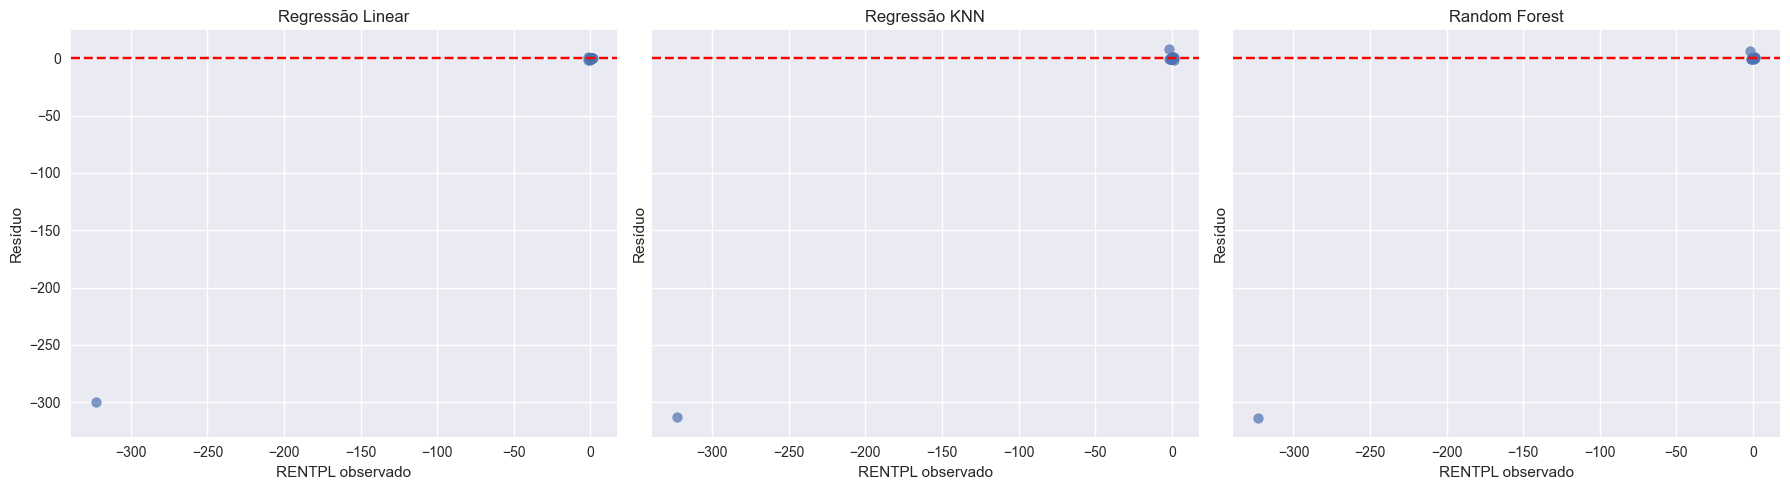

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (model_name, df_res) in zip(axes, residuals_data.items()):
    ax.scatter(df_res["RENTPL"], df_res["Residuo"], alpha=0.7)
    ax.axhline(0, color="red", linestyle="--")
    ax.set_title(model_name)
    ax.set_xlabel("RENTPL observado")
    ax.set_ylabel("Resíduo")

plt.tight_layout()
plt.show()

## 11. Selecionar Melhor Modelo
Avaliamos todas as métricas e gráficos de resíduos para justificar o modelo preferido.

In [18]:
test_metrics = (
    metrics_df[metrics_df["Base"] == "Teste"]
    .drop_duplicates(subset="Modelo", keep="last")
    .set_index("Modelo")
)

melhor_rmse = test_metrics["RMSE"].idxmin()
melhor_r2 = test_metrics["R2"].idxmax()
melhor_mae = test_metrics["MAE"].idxmin()

rmse_val = float(test_metrics.loc[melhor_rmse, "RMSE"])
r2_val = float(test_metrics.loc[melhor_r2, "R2"])
mae_val = float(test_metrics.loc[melhor_mae, "MAE"])

resumo = (
    f"Menor RMSE de teste: **{melhor_rmse}** ({rmse_val:.4f})\\n"
    f"Maior R² de teste: **{melhor_r2}** ({r2_val:.4f})\\n"
    f"Menor MAE de teste: **{melhor_mae}** ({mae_val:.4f})"
)

variancia_min = (
    variance_df.reset_index()
    .drop_duplicates(subset="Modelo", keep="last")
    .set_index("Modelo")[["|Δ RMSE|", "|Δ R2|", "|Δ MAE|"]]
    .sum(axis=1)
    .idxmin()
)

justificativa = (
    "A escolha do melhor modelo deve considerar o equilíbrio dos erros e a estabilidade entre as bases." 
)

display(Markdown(resumo))
display(Markdown(justificativa))

Menor RMSE de teste: **Regressão Linear** (34.6577)\nMaior R² de teste: **Regressão Linear** (0.1256)\nMenor MAE de teste: **Regressão Linear** (4.2080)

A escolha do melhor modelo deve considerar o equilíbrio dos erros e a estabilidade entre as bases.